In [1]:
# Libs
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import pandas as pd
import numpy as np


# Plot size
plt.rcParams["figure.figsize"] = [10, 5]

# Load and prepare data
nomes = pd.read_csv("../raw_data/nomes.csv")
nomes.loc[:, "first_name"] = nomes.first_name.str.lower().str.strip()

In [ ]:
# Plot names' length
(nomes.assign(tam = nomes.first_name.str.len())
    .groupby("tam")
    .size()
    .plot.bar()
)

In [2]:
# Create function to sample and prepare data
def draw_names_sample(nomes, n):

    smp = nomes.sample(n)
    y = np.random.binomial(1, smp.prop_female, n)
    x = smp.first_name
    return y, x

In [44]:
# A sample for testing
np.random.seed(222)
Y, first_names = draw_names_sample(nomes, 50000)

In [45]:
# Valid letters
chars = set("".join(first_names))
chars.add("DUMMY")
chars_index = dict((c, i) for i, c in enumerate(chars))
index_chars = dict((i, c) for i, c in enumerate(chars))

In [38]:
# Function to one-hot encode names
def one_hot(nome, chars_index, pad=20):

    nome_trunc = nome[:pad]
    res = []
    for i in [chars_index[ch] for ch in nome_trunc]:
        nome_vector = np.zeros(len(chars_index))
        nome_vector[i] = 1
        res.append(nome_vector)
    
    for i in range(0, pad - len(res)):
        dummy = np.zeros(len(chars_index))
        dummy[chars_index["DUMMY"]] = 1
        res.append(dummy)

    return np.vstack(res)

# Transform names
X_first_names = list(map(lambda x: one_hot(x, chars_index), first_names))
X_first_names = np.asarray(X_first_names)


In [40]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_first_names, Y, random_state=222)

In [41]:
# Build a test model
model = keras.Sequential()
model.add(layers.Bidirectional(layers.LSTM(256, return_sequences=True), 
                               input_shape=(20, len(chars_index))))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activity_regularizer=keras.regularizers.l2(0.002)))
model.add(layers.Activation("sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_8 (Bidirection (None, 20, 512)           581632    
_________________________________________________________________
dropout_7 (Dropout)          (None, 20, 512)           0         
_________________________________________________________________
dense_8 (Dense)              (None, 20, 1)             513       
_________________________________________________________________
activation_7 (Activation)    (None, 20, 1)             0         
Total params: 582,145
Trainable params: 582,145
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Defines early stoping
cb = EarlyStopping(patience=5)

In [42]:
# Training
history = model.fit(X_train, y_train, batch_size=128, epochs=100, 
                    verbose=1, validation_data=(X_test, y_test),
                    callbacks = cb)

Epoch 1/100
59/59 [==============================] - 19s 264ms/step - loss: 0.6556 - accuracy: 0.6158 - val_loss: 0.5340 - val_accuracy: 0.7907
Epoch 2/100
59/59 [==============================] - 15s 254ms/step - loss: 0.5155 - accuracy: 0.8151 - val_loss: 0.4881 - val_accuracy: 0.8322
Epoch 3/100
59/59 [==============================] - 15s 255ms/step - loss: 0.4843 - accuracy: 0.8426 - val_loss: 0.4754 - val_accuracy: 0.8488
Epoch 4/100
59/59 [==============================] - 16s 268ms/step - loss: 0.4711 - accuracy: 0.8518 - val_loss: 0.4539 - val_accuracy: 0.8639
Epoch 5/100
59/59 [==============================] - 15s 262ms/step - loss: 0.4582 - accuracy: 0.8605 - val_loss: 0.4468 - val_accuracy: 0.8714
Epoch 6/100
59/59 [==============================] - 15s 253ms/step - loss: 0.4402 - accuracy: 0.8775 - val_loss: 0.4417 - val_accuracy: 0.8757
Epoch 7/100
59/59 [==============================] - 16s 268ms/step - loss: 0.4293 - accuracy: 0.8840 - val_loss: 0.4334 - val_accuracy:

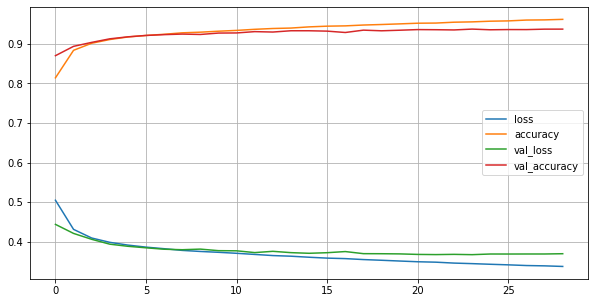

In [57]:
pd.DataFrame(history.history).plot()
plt.grid(True)